# Prostate Zones Segmentation - Atlas-based
Train a model using the ProstateX data for training and test on the Prostate3T. This study assumes that a  prostate gland mask is available as an input, which is a reasonable assumption since this follows the current standard of care.

In [1]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
import torch
from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandRotated, \
    RandSpatialCropd, \
    Resized, \
    RandFlipd, CropForegroundd, RandWeightedCropd, \
    LabelToMaskd, ScaleIntensityRanged, \
    CopyItemsd, DeleteItemsd, Lambdad, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, KeepLargestConnectedComponent, \
    AsDiscrete 
from monai.data import list_data_collate,decollate_batch
from monai.networks.layers import Norm

from monai.visualize import img2tensorboard
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference

monai.config.print_config()

MONAI version: 0.6.0
Numpy version: 1.19.2
Pytorch version: 1.10.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: 0.17.2
Pillow version: 8.1.0
Tensorboard version: 2.2.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.55.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.1
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Verify System Setup
Check torch and CUDA on the system.

In [2]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000
GPU 1: Quadro RTX 8000
GPU 2: Quadro RTX 8000


## Set the project path

In [3]:
EXP_NAME = 'Gland_Mask_Resized_Full_CE_Atlas'
ROOT_PATH = r'../resources/model/'
# ROOT_PATH = sys.path[0]
EXP_PATH = os.path.join(ROOT_PATH,EXP_NAME.lower())

# Create the study directory structure
if not os.path.exists(EXP_PATH):
    print('Creating experiment directory: {}'.format(EXP_PATH))
    os.mkdir(EXP_PATH)

print('Using experiment directory: {}'.format(EXP_PATH))


Using experiment directory: ../resources/model/gland_mask_resized_full_ce_atlas


## Load the Data

In [4]:
PROSTATEX_PATH = r'../resources/data/ProstateX_data_index.csv'

df = pd.read_csv(PROSTATEX_PATH, index_col=False)
df = df.dropna(subset=['SEGM_PIRADS'])
df.drop_duplicates(inplace=True)
df = df.rename(columns={
    'SEGM_PIRADS': 'SEGM',
    'IMAGE': 'IMAGE'
})

print('Dataset contains %d entries' % len(df))
df.head(5)

Dataset contains 98 entries


,SUBJECT_ID,VISIT_ID,IMAGE,SEGM,DATASET_ID
5,4,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
8,7,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
10,9,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
15,12,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX
18,15,0,/data16/public/prostate/data/public/from_tenso...,/data16/public/prostate/data/public/from_tenso...,ProstateX


In [5]:
PROSTATE3T_PATH = r'../resources/data/Prostate3T_data_index.csv'

df_test = pd.read_csv(PROSTATE3T_PATH, index_col=False)
df_test.drop_duplicates(inplace=True)

print('Dataset contains %d entries' % len(df_test))
df_test.head(5)

Dataset contains 30 entries


,SUBJECT_ID,IMAGE,SEGM,SEGM_PROSTATE,DATASET_ID
0,1,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
1,2,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
2,3,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
3,4,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T
4,5,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,/data16/public/prostate/data/public/TCIA/Prost...,Prostate3T


In [6]:
# Convert DF to dictionary
train_data_dict = df.to_dict('records')
test_data_dict = df_test.to_dict('records')

print('Number of training files: ', len(train_data_dict))
print('Number of testing files: ', len(test_data_dict))

Number of training files:  98
Number of testing files:  30


## Setup Input Transformations

In [8]:
SPACING = (1,1,3)
RESIZE_SIZE = (96,96,32)
MARGIN = 8

train_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    # Standardize spacing so that the margin is consistent around all glands
    Spacingd(keys=['IMAGE', 'SEGM'], 
             pixdim=SPACING, mode=('bilinear', 'nearest'), 
             padding_mode=('reflection','reflection')),
    CropForegroundd(keys=['IMAGE', 'SEGM'], 
                source_key='SEGM', select_fn=lambda x: x > 0, margin=MARGIN),
    Resized(keys=['IMAGE', 'SEGM'], spatial_size=RESIZE_SIZE, mode=["trilinear","nearest"]),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    # Copy the SEGM image to create a gland mask image GLAND
    CopyItemsd(keys=['SEGM'], times=1, names=['GLAND']),
    # Create the gland mask from all SEGM values > 0
    LabelToMaskd(keys=['GLAND'], select_labels=[1,2,3,4], merge_channels=True),
    # Create the PZ mask from the SEGM values == 1
    LabelToMaskd(keys=['SEGM'], select_labels=[2,3,4], merge_channels=True),
    RandFlipd(keys=['IMAGE', 'SEGM','GLAND'], prob=0.5, spatial_axis=[0]),
    ToTensord(keys=['IMAGE', 'SEGM','GLAND'])
])

test_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], 
             pixdim=SPACING, mode=('bilinear', 'nearest'), 
             padding_mode=('reflection','reflection')),
    CropForegroundd(keys=['IMAGE', 'SEGM'], 
                    source_key='SEGM', select_fn=lambda x: x > 0, margin=MARGIN),
    Resized(keys=['IMAGE', 'SEGM'], spatial_size=RESIZE_SIZE, mode=["trilinear","nearest"]),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    # Copy the SEGM image to create a gland mask image GLAND and a copy to preserve the 2 class segm result
    CopyItemsd(keys=['SEGM'], times=2, names=['GLAND','SEGM2']),
    # Create the gland mask from all SEGM values > 0
    LabelToMaskd(keys=['GLAND'], select_labels=[1,2], merge_channels=True),
    # Create the PZ mask from the SEGM values == 1
    LabelToMaskd(keys=['SEGM'], select_labels=[2], merge_channels=True),
    ToTensord(keys=['IMAGE', 'SEGM','GLAND','SEGM2'])
])

## Check Input Data

['SUBJECT_ID', 'IMAGE', 'SEGM', 'SEGM_PROSTATE', 'DATASET_ID', 'IMAGE_meta_dict', 'SEGM_meta_dict', 'IMAGE_transforms', 'SEGM_transforms', 'foreground_start_coord', 'foreground_end_coord', 'GLAND', 'SEGM2', 'GLAND_transforms', 'SEGM2_transforms']
IMAGE shape: torch.Size([3, 1, 96, 96, 32]), SEGM shape: torch.Size([3, 1, 96, 96, 32])
image shape: torch.Size([96, 96, 32]), label shape: torch.Size([96, 96, 32])
image mean: 0.047944799065589905


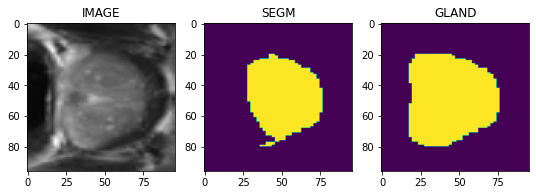

image shape: torch.Size([96, 96, 32]), label shape: torch.Size([96, 96, 32])
image mean: 0.0426282100379467


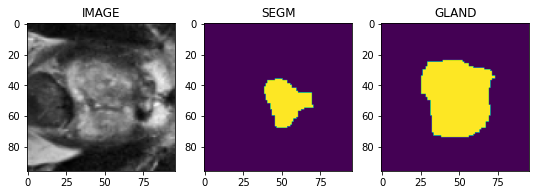

image shape: torch.Size([96, 96, 32]), label shape: torch.Size([96, 96, 32])
image mean: 0.0052947974763810635


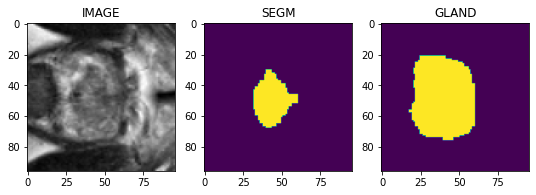

In [10]:
# check_ds = monai.data.Dataset(data=train_data_dict[:4], transform=train_transforms)
check_ds = monai.data.Dataset(data=test_data_dict[:4], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=3, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)

print(list(check_data))
print('IMAGE shape: {}, SEGM shape: {}'
      .format(check_data['IMAGE'].shape, check_data['SEGM'].shape))

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image = check_data['IMAGE'][i][0]
    label = check_data['SEGM'][i][0]
    mask = check_data['GLAND'][i][0]

    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//3
    
    plt.figure('check', (9, 3))
    plt.subplot(1, 3, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.subplot(1, 3, 3)
    plt.title('GLAND')
    plt.imshow(mask[:,:,slice_num])
    plt.show()

## Create a Data Cache for Training and Validation Data

In [11]:
train_ds = monai.data.CacheDataset(
    data=train_data_dict, transform=train_transforms, cache_rate=1.0, num_workers=10
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

Loading dataset: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]


## Create Dataset for Testing Data

In [12]:
test_ds = monai.data.CacheDataset(
    data=test_data_dict, transform=test_transforms, cache_rate=1.0, num_workers=10
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 30/30 [00:04<00:00,  6.34it/s]


## Load the Atlas

In [13]:
root_eigen = '../resources/cg_atlas/'

fn_CG_eigenvectors = os.path.join(root_eigen,'CG_segm_eigenvectors_16.npz')
CG_eigenvectors = monai.transforms.LoadImage(reader='NumpyReader')(fn_CG_eigenvectors)

fn_CG_eigenvalues = os.path.join(root_eigen,'CG_segm_eigenvalues_16.npz')
CG_eigenvalues = monai.transforms.LoadImage(reader='NumpyReader')(fn_CG_eigenvalues)

print(CG_eigenvectors[0].shape)
print(CG_eigenvalues[0].shape)

(17, 1, 96, 96, 32)
(17,)


In [14]:
CG_eigenvectors_tensor = torch.tensor(CG_eigenvectors[0])
print(CG_eigenvectors_tensor.shape)
CG_eigenvalues_tensor = torch.tensor(CG_eigenvalues[0])
print(CG_eigenvalues_tensor.shape)

torch.Size([17, 1, 96, 96, 32])
torch.Size([17])


In [15]:
M = torch.unsqueeze(CG_eigenvectors_tensor[0], dim=0)
print(M.shape)
M_back = 1-M
M = torch.cat((M_back,M),dim=1)
print(M.shape)

torch.Size([1, 1, 96, 96, 32])
torch.Size([1, 2, 96, 96, 32])


## Create the Model

In [31]:
class CGSegm(pytorch_lightning.LightningModule):

    def __init__(self, eigenmean, dropout=0.0):
        super().__init__()
        
        self.dropout = dropout
        self.eigenmean = eigenmean
              
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=2, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout=self.dropout
        )
        
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.softmax_transform = torch.nn.Softmax(dim=1)
        self.val_dice_function = monai.metrics.DiceMetric(include_background=False)
        
    def forward(self, x, lambd, mask):
        
        output_shape = list(x.shape[:1])
        M = torch.tile(self.eigenmean, (output_shape[0],1,1,1,1))

        x = self._model(x)
        x = self.softmax_transform(x)
        
        y = (torch.mul(lambd, M.view(output_shape[0],-1)) + \
            torch.mul((1-lambd), x.view(output_shape[0],-1))).view(x.shape)
        
        mask = torch.stack([self.one_hot_transform(i) for i in decollate_batch(mask)])
        mask_c1 = mask[:,1:,...]
        mask_c0 = mask[:,:1,...]

        y_c1 = y[:,1:,...]
        y_c1 = torch.mul(y_c1, mask_c1)
        y_c0 = y[:,:1,...]
        y_c0 = torch.where(mask_c0!=0,mask_c0,y_c0)
        y = torch.cat((y_c0,y_c1),dim=1)
        
        return y

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]
        masks = batch["GLAND"]
        
        x = torch.cat([images,masks], dim=1) # 2 channels
        
        output_shape = list(x.shape[:1])
        lambd = torch.rand((output_shape[0],1)).to(device)
        
        self.batch_idx = batch_idx
        outputs = self.forward(x, lambd, masks)
        
        loss = self.loss_function(outputs, torch.squeeze(labels, dim=1).long())
        
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Train/Input')
            img2tensorboard.plot_2d_or_3d_image(data=masks, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Train/InputMask')
            img2tensorboard.plot_2d_or_3d_image(data=torch.argmax(outputs, dim=1, keepdim=True), 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Train/Output')        
        
        return {"loss": loss}
        
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            sample_input = torch.rand((1,2,96,96,32))
            lambd = torch.rand((1,1))
            mask = torch.rand((1,1,96,96,32))
            self.logger.experiment.add_graph(
                CGSegm(self.eigenmean.cpu()), 
                [sample_input,lambd,mask])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
           
    
    def validation_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]
        masks = batch["GLAND"]

        x = torch.cat([images,masks], dim=1)
        
        output_shape = list(x.shape[:1])
        lambd = torch.rand((output_shape[0],1)).to(device)
        
        self.batch_idx = batch_idx
        outputs = self.forward(x, lambd, masks)

        loss = self.loss_function(outputs, torch.squeeze(labels, dim=1).long())

        argmax = torch.argmax(outputs, dim=1, keepdim=True)
    
        y_pred_onehot = torch.stack([self.one_hot_transform(i) for i in decollate_batch(argmax)])
        y_onehot = torch.stack([self.one_hot_transform(i) for i in decollate_batch(labels)])
        
        val_dice = self.val_dice_function(y_pred_onehot,y_onehot)        
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}

    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        total_dice = torch.stack([x['val_dice'][0] for x in outputs])
        filtered_total_dice = total_dice[~torch.any(total_dice.isnan(),dim=1)]
        avg_dice = filtered_total_dice.mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        self.log('val_loss',avg_loss) # save best model according to this

    
    def configure_optimizers(self):
        trainable_params = list(self.parameters()) 
       
        opt = torch.optim.Adam(trainable_params, lr=5e-4)
        scheduler = {'scheduler': torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=10, gamma=0.98),
                     'name': 'Learning Rate'}
        return [opt], [scheduler]
    
    

In [17]:
from torchinfo import summary
# from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CGSegm(
    eigenmean=M.to(device), 
    dropout=0.3,
).to(device)
summary(model, [(4,2,96,96,32),(1,1),(4,1,96,96,32)], device=device)
# summary(model, (2,96,96,32))

Layer (type:depth-idx)                                                           Output Shape              Param #
CGSegm                                                                           --                        --
├─UNet: 1-1                                                                      [4, 2, 96, 96, 32]        --
│    └─Sequential: 2-1                                                           [4, 2, 96, 96, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [4, 16, 48, 48, 16]       8,754
│    │    └─SkipConnection: 3-2                                                  [4, 32, 48, 48, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [4, 2, 96, 96, 32]        1,845
├─Softmax: 1-2                                                                   [4, 2, 96, 96, 32]        --
Total params: 1,188,785
Trainable params: 1,188,785
Non-trainable params: 0
Total mult-adds (G): 15.20

## Train the Model Using Lightning Training Loop

In [18]:
MODEL_PATH = os.path.join(EXP_PATH,'saved_model')
print('MODEL_PATH={}'.format(MODEL_PATH))

MODEL_PATH=../resources/model/gland_mask_resized_full_ce_atlas/saved_model


In [18]:
# initialise the LightningModule
device = torch.device("cuda:1")

model = CGSegm(
    eigenmean=M.to(device), 
    dropout=0.3,
)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_PATH,'logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=MODEL_PATH,
    filename="{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_PATH,'last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_PATH,'last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=3000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=10,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=test_loader)
# IPython.display.clear_output()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name              | Type             | Params
-------------------------------------------------------
0 | _model            | UNet             | 1.2 M 
1 | loss_function     | CrossEntropyLoss | 0     
2 | softmax_transform | Softmax          | 0     
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/monai/networks/utils.py:80: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sh[dim] != 1:


Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Saving latest checkpoint...


1

## Perform Inference on the Data


In [30]:
RESULTS_PATH = os.path.join(EXP_PATH,'results')

if not os.path.exists(RESULTS_PATH):
    print('Creating experiment directory: {}'.format(RESULTS_PATH))
    os.mkdir(RESULTS_PATH)

print('Using experiment directory: {}'.format(RESULTS_PATH))

Creating experiment directory: ../resources/model/gland_mask_resized_full_ce_atlas/results
Using experiment directory: ../resources/model/gland_mask_resized_full_ce_atlas/results


In [20]:
# Load 
model_path = os.path.join(MODEL_PATH,'last.ckpt')
print('Loading saved model from: {}'.format(model_path))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CGSegm.load_from_checkpoint(model_path,
                                    eigenmean=M.to(device) 
                                   )

Loading saved model from: ../resources/model/gland_mask_resized_full_ce_atlas/saved_model/last.ckpt


In [23]:
from monai.inferers import sliding_window_inference

# Import utils
from importlib import reload
import segmplot
import visualization as viz
import time
reload(segmplot)


def run_inference_and_evaluate(model, batch, roi_size=(96, 96, 32), 
                               plot_images=False, save_output=False, 
                               sw_batch_size=4, lambd=0):
    """Inference and evaluation function for PZ segmentation.
    
    """
    
    # Use MONAI one_hot transform
    one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=3)
    
    with torch.no_grad():                
        x1 = test_data['IMAGE'].to(device)
        x2 = test_data['GLAND'].to(device)
        y = test_data['SEGM2'].cpu()
        
        x = torch.cat([x1,x2], dim=1)
        
        lambd_tensor = (torch.ones(1,1)*lambd).to(device)
        
        start_time = time.time()
        y_pred = model.forward(x, lambd_tensor, x2)
        stop_time = time.time()
        
        inference_time = stop_time-start_time
        
        argmax = torch.argmax(y_pred, dim=1, keepdim=True)
        argmax = argmax.detach().cpu()

        # Convert y and y_pred back to 2-class segms
        x2 = x2.type(dtype=torch.int64).detach().cpu()
        y2 = x2 + argmax

        y_onehot = torch.stack([one_hot_transform(i) for i in decollate_batch(y)])
        y_pred_onehot = torch.stack([one_hot_transform(i) for i in decollate_batch(y2)])      

        # Evaluate segmentation metrics
        eval_list = list()
        zonal_bounds, zonal_ids = viz.compute_pirads_zone_bounds(x2[0,0,...].numpy())
        for b, zid in zip(zonal_bounds, zonal_ids):
                    
            zone_pred_onehot = y_pred_onehot[...,slice(b[0], b[1])]
            zone_onehot = y_onehot[...,slice(b[0], b[1])]
            
            dice_values, hd_values, mad_values = viz.compute_evaluation_metrics(
                y_pred=zone_pred_onehot, y=zone_onehot
            )
            # print(dice_values)        
    
            df_metrics = pd.DataFrame()
            df_metrics['ROI'] = ['PZ','CG']
            df_metrics['ROI_VALUE'] = np.arange(len(dice_values))+1
            df_metrics['DICE'] = dice_values
            df_metrics['HD95'] = hd_values
            df_metrics['MAD'] = mad_values
            df_metrics['ZONAL_ID'] = zid
            eval_list.append(df_metrics)

        # Concat all the zonal segm results
        df_eval = pd.concat(eval_list)
        # Global eval values
        df_eval['INFERENCE_TIME'] = inference_time
        df_eval['DATASET_ID'] = test_data['DATASET_ID'][0]
        df_eval['SUBJECT_ID'] = test_data['SUBJECT_ID'][0].cpu().numpy()
        df_eval['IMAGE'] = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
        df_eval['SEGM'] = test_data['SEGM_meta_dict']['filename_or_obj'][0]
        
        
        if plot_images:
            # Ensure that image is CxHxWxD
            image = x1[0,...].cpu().numpy()
            segm = y[0,...].cpu().numpy()
            pred = y_pred_onehot[0,...].cpu().numpy()
            
            # axial plot
            plot_axial = segmplot.PlotSegmentation(
                num_slices=3, 
                slice_spacing=1, 
                slice_axis=3, 
            )
            plt.figure('segm', (20,5))
            plot_axial(image, [pred],  cmap_name=['tab10'])
            plt.show()
            
            plt.figure('segm', (20,5))
            plot_axial(segm, [pred], cmap_name=['tab10'])
            plt.show()
            
            # sagittal plot
            plot_sagittal = segmplot.PlotSegmentation(
                num_slices=3, 
                slice_spacing=6, 
                slice_axis=1, 
            )
            
            plt.figure('segm', (20,5))
            plot_sagittal(segm, [pred], cmap_name=['tab10'])
            plt.show()

        
        # Write data out
        if save_output:
            test_data['PRED'] = y2
            # save inference transforms
            save_transforms = Compose([
                monai.transforms.AsDiscreted(keys="PRED", to_onehot=True, n_classes=3),
                monai.transforms.Invertd(
                    keys="PRED",
                    transform=test_transforms,
                    orig_keys="IMAGE",
                    orig_meta_keys="IMAGE_meta_dict",
                    meta_keys="PRED_meta_dict",
                    meta_key_postfix="meta_dict",
                    nearest_interp=False,
                    to_tensor=True,
                ),
                monai.transforms.AsDiscreted(keys="PRED", argmax=True),
                monai.transforms.SaveImaged(keys="PRED", meta_keys="PRED_meta_dict", 
                                            output_dir='{}_lambd{}'.format(RESULTS_PATH, current_lambd), 
                                            output_postfix='infer_seg', 
                                            resample=False),])
            
            d = [save_transforms(i) for i in decollate_batch(test_data)]
            
        return df_eval

Current lambd 0.4...
Evaluating Subject 8...


/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/monai/metrics/utils.py:195: UserWarning: ground truth is all 0, this may result in nan/inf distance.
  warnings.warn("ground truth is all 0, this may result in nan/inf distance.")
/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/monai/metrics/utils.py:199: UserWarning: prediction is all 0, this may result in nan/inf distance.
  warnings.warn("prediction is all 0, this may result in nan/inf distance.")


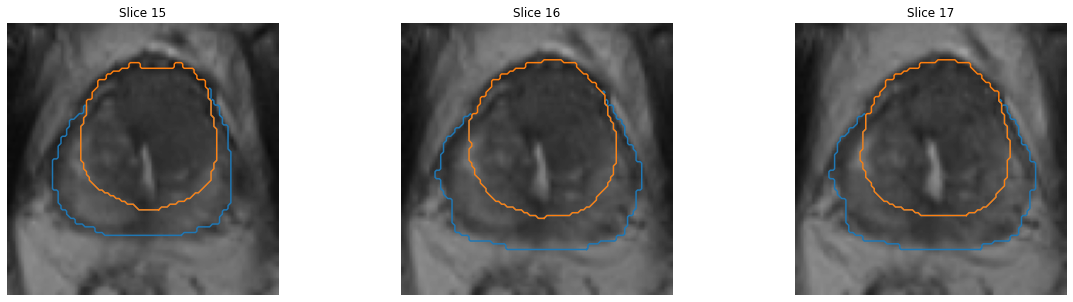

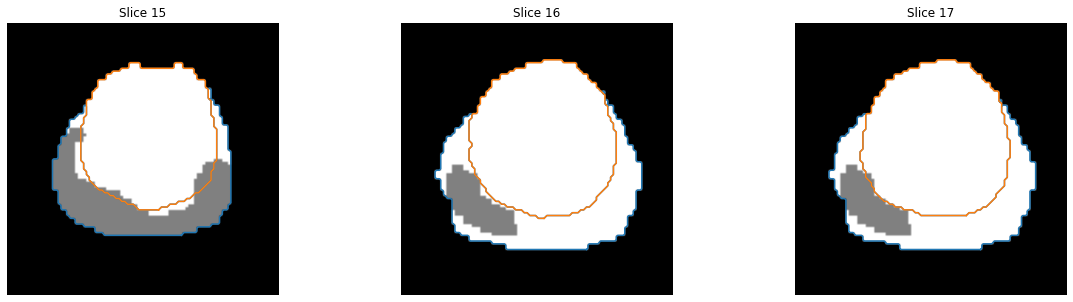

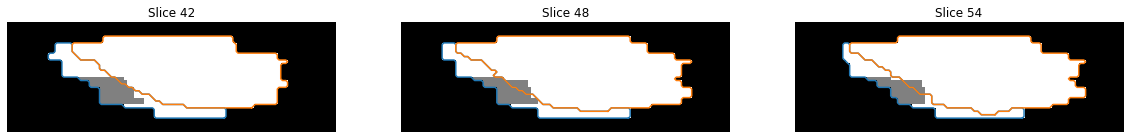

/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


file written: /data16/public/prostate/doc/hyperlambda/2022MICCAI/github_repo/resources/model/gland_mask_resized_full_ce_atlas/results_lambd0.4/Prostate3T-01-0008/Prostate3T-01-0008_infer_seg.nii.gz.
Using CSV_NAME name: CG_Gland_Mask_Resized_Full_CE_atlas_lambd0.4
../resources/model/gland_mask_resized_full_ce_atlas/results/CG_Gland_Mask_Resized_Full_CE_atlas_lambd0.4_results.csv
Current lambd 1.0...
Evaluating Subject 8...


/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/monai/metrics/utils.py:195: UserWarning: ground truth is all 0, this may result in nan/inf distance.
  warnings.warn("ground truth is all 0, this may result in nan/inf distance.")
/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/monai/metrics/utils.py:199: UserWarning: prediction is all 0, this may result in nan/inf distance.
  warnings.warn("prediction is all 0, this may result in nan/inf distance.")


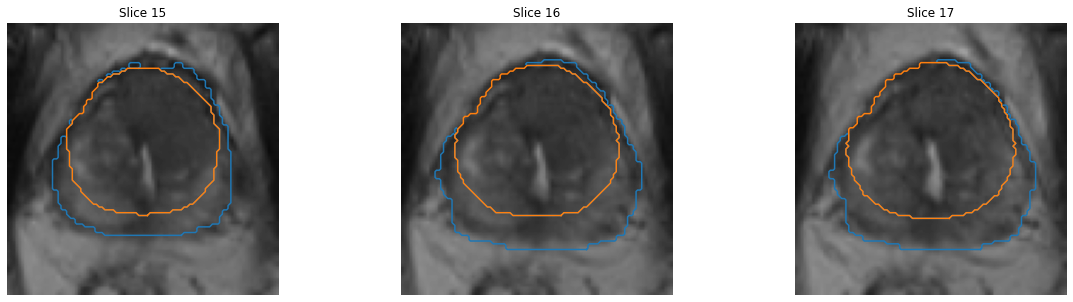

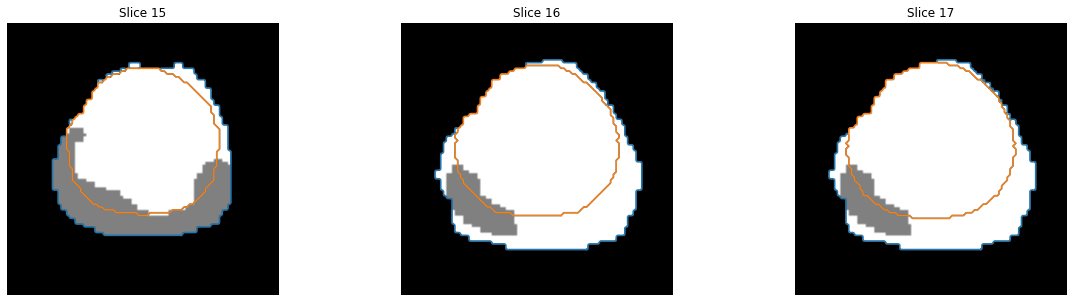

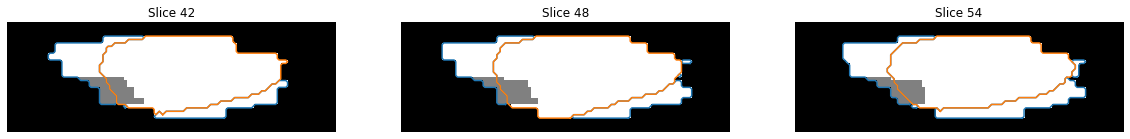

/home1/jz729/anaconda3/envs/monai_pirads/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


file written: /data16/public/prostate/doc/hyperlambda/2022MICCAI/github_repo/resources/model/gland_mask_resized_full_ce_atlas/results_lambd1.0/Prostate3T-01-0008/Prostate3T-01-0008_infer_seg.nii.gz.
Using CSV_NAME name: CG_Gland_Mask_Resized_Full_CE_atlas_lambd1.0
../resources/model/gland_mask_resized_full_ce_atlas/results/CG_Gland_Mask_Resized_Full_CE_atlas_lambd1.0_results.csv


In [29]:
model.eval()
model.to(device)

lambd_array = [0.4, 1.0]
sub_idx = 7

for j, current_lambd in enumerate(lambd_array):
    evaluation_results = list()
    print('Current lambd {}...'.format(current_lambd))
    for i, test_data in enumerate(test_loader):
        if i != sub_idx:
            continue

        print('Evaluating Subject {}...'.format(i+1))
        df_eval = run_inference_and_evaluate(
            model=model, 
            batch=test_data,  
            plot_images=True, 
            save_output=True,
            lambd = current_lambd
        )
        evaluation_results.append(df_eval)

    df_results = pd.concat(evaluation_results)

    CSV_NAME = 'CG_{}_lambd{}'.format(EXP_NAME, current_lambd)
    print('Using CSV_NAME name: {}'.format(CSV_NAME))
    df_results['EXPERIMENT_ID'] = CSV_NAME
    
    df_results.to_csv(os.path.join(RESULTS_PATH,'{}_results.csv'.format(CSV_NAME)), index=False)
    print(os.path.join(RESULTS_PATH,'{}_results.csv'.format(CSV_NAME)))